# Modeling

In this notebook we use a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. I have commented out some cells/models. At the bottom of the notebook I selected the final/best model and hyperparameters to run one time only and then made the business performance tables for that final model. 

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [64]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [65]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [66]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [ ]:
%%time
vars = pd.read_csv('features/vars_final.csv')
print(vars.shape)
vars.head()

(98037, 22)
CPU times: user 101 ms, sys: 18.1 ms, total: 119 ms
Wall time: 126 ms


,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,...,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7,Recnum,Fraud
0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,1,0.0
1,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,2,0.0
2,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,3,0.0
3,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,4,0.0
4,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,5,0.0


In [68]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'card_state_total_3',
 'card_state_total_amount_1_by_60',
 'Cardnum_max_14',
 'card_zip_count_1_by_60',
 'card_state_count_1_by_30_sq',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_state_des_30',
 'Card_dow_unique_count_for_merch_state_14',
 'Card_dow_unique_count_for_merch_zip_14']

In [69]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [70]:
vars.shape

(98037, 12)

In [71]:
vars['Fraud'].sum()

2492.0

In [72]:
print("fraud rate in data is",(vars['Fraud'].sum()/len(vars)).round(4))

fraud rate in data is 0.0254


In [73]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
5,6,0.0,1.0,3.67,0.016667,3.67,0.016667,0.001111,0.000278,1.0,1.0,1.0
6,7,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
7,8,0.0,1.0,230.32,0.016667,230.32,0.016667,0.001111,0.000278,1.0,1.0,1.0
8,9,0.0,1.0,62.11,0.016667,62.11,0.016667,0.001111,0.000278,1.0,1.0,1.0
9,10,0.0,1.0,10.86,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [74]:
vars.shape

(98037, 12)

In [75]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,49185.587992,0.025419,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,28418.418181,0.157395,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.000000,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,24564.000000,0.000000,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,49186.000000,0.000000,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,73808.000000,0.000000,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,98393.000000,1.000000,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [76]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85725]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
85396,85726,0.0,1.0,789.32,0.016667,609.34,0.016667,0.001111,0.000278,1.0,1.0,1.0
85397,85727,0.0,1.0,235.00,0.016667,399.15,0.016667,0.001111,0.000046,1.0,1.0,1.0
85398,85728,0.0,1.0,600.00,0.016667,600.00,0.016667,0.001111,0.000278,1.0,1.0,1.0
85399,85729,0.0,1.0,30.00,0.001265,30.00,0.008333,0.000556,0.000031,1.0,1.0,1.0
85400,85730,0.0,1.0,182.00,0.004183,1573.30,0.016667,0.000556,0.000008,3.0,2.0,2.0
85401,85731,0.0,1.0,174.61,0.007283,225.00,0.008333,0.000556,0.000139,1.0,1.0,1.0
85402,85732,0.0,1.0,259.90,0.000311,395.00,0.001515,0.000159,0.000010,2.0,3.0,3.0
85403,85733,0.0,1.0,25.00,0.000346,531.25,0.005556,0.000222,0.000019,3.0,3.0,3.0
85404,85734,0.0,1.0,97.17,0.000987,395.04,0.016667,0.000556,0.000019,1.0,1.0,1.0
85405,85735,0.0,1.0,6.51,0.003082,6.51,0.005556,0.000556,0.000093,1.0,1.0,1.0


In [77]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [78]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [79]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [80]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [81]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04
mean,-5.740178e-17,7.827516e-18,4.406601e-17,-2.609172e-18,-2.783117e-17,9.277056e-18,8.697240e-19,1.971374e-17,2.551190e-17,-2.899080e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.624561e-01,-3.535511e-01,-1.206679e+00,-7.218116e-01,-1.805445e+00,-1.635089e+00,-7.282828e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
25%,-4.624561e-01,-3.196503e-01,-9.732673e-01,-5.323110e-01,-9.003706e-01,-9.442087e-01,-5.488119e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
50%,-4.624561e-01,-2.409018e-01,-3.101716e-01,-2.280658e-01,9.197603e-01,-2.467484e-01,-3.604359e-01,-4.318418e-01,-1.457875e-01,-1.465178e-01
75%,1.490252e-01,-1.315083e-02,1.299601e+00,3.465037e-01,9.197603e-01,1.148172e+00,7.910798e-02,1.647688e-01,2.995206e-01,2.985779e-01
max,1.004780e+01,2.116989e+01,1.299601e+00,1.137486e+01,9.197603e-01,1.148172e+00,4.160587e+00,1.007561e+01,1.031861e+01,1.031776e+01


In [82]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85400
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    356.0
dtype: float64

## Look at PCA

In [83]:
len(X_trntst.columns)

10

In [84]:
X_trntst_save = X_trntst.copy()

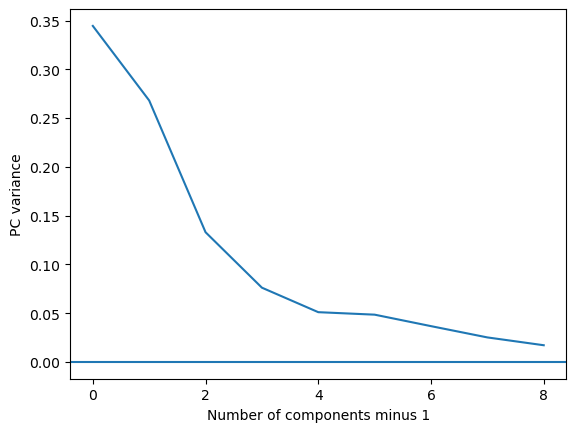

In [85]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [86]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-2.298592,2.828930,-1.044553,2.853312
1,-2.294038,2.831059,-1.023337,2.855314
2,-2.269947,2.842318,-0.911097,2.865906
3,-2.298592,2.828930,-1.044553,2.853312
4,-2.298448,2.829098,-1.043171,2.853872


In [87]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85400,-0.271263,-0.301918,0.152177,-0.789034
85401,-1.411576,-0.134906,-0.549871,1.599018
85402,0.354204,-2.270881,-0.356633,0.329590
85403,0.396363,-1.803357,-0.444931,0.211623
85404,-1.111503,-0.669822,-0.198713,-0.544822


In [88]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000
mean,0.005402,0.001902,-0.007191,0.003646,-0.016853,-0.016394,0.000793,0.018604,0.004191,0.004150
std,1.010079,1.015093,1.000565,0.986430,1.008559,1.003052,1.015169,1.025655,1.015940,1.015793
min,-0.462456,-0.353551,-1.206679,-0.721812,-1.805445,-1.635089,-0.728283,-0.730147,-0.591096,-0.591614
25%,-0.462456,-0.319930,-0.978909,-0.528642,-0.900371,-0.944209,-0.555789,-0.730147,-0.591096,-0.591614
50%,-0.462456,-0.241329,-0.325085,-0.219636,0.822253,-0.246748,-0.360436,-0.431842,-0.145788,-0.146518
75%,0.149025,-0.013151,1.299601,0.354197,0.919760,1.148172,0.079108,0.164769,0.299521,0.298578
max,10.047803,21.169890,1.299601,11.374863,0.919760,1.148172,4.160587,10.075611,10.318614,10.317765


In [89]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.162351,0.136121,0.000288,-0.086914
std,1.661656,1.508477,1.103300,0.810441
min,-2.298898,-2.868975,-4.088040,-2.742315
25%,-1.155412,-1.110489,-0.429237,-0.622208
50%,-0.553779,-0.026500,-0.214440,-0.135327
75%,0.352563,1.480842,0.188719,0.283837
max,17.779793,7.010407,22.850611,6.264188


In [90]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [91]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.540000e+04,8.540000e+04,8.540000e+04,8.540000e+04
mean,-2.263087e-17,1.664035e-17,-4.659297e-18,6.656138e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.226852e+00,-1.775766e+00,-4.261524e+00,-3.258578e+00
25%,-5.685818e-01,-8.226536e-01,-3.813573e-01,-6.515316e-01
50%,-2.173434e-01,-1.286156e-01,-1.719380e-01,-5.239055e-02
75%,2.924765e-01,8.901791e-01,1.811218e-01,4.049477e-01
max,1.149504e+01,4.654491e+00,1.977602e+01,7.850799e+00


In [92]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.086632,0.082347,0.000247,-0.098665
std,0.886675,0.912554,0.947611,0.920021
min,-1.226713,-1.735588,-3.511168,-3.113102
25%,-0.616539,-0.671791,-0.368667,-0.706336
50%,-0.295502,-0.016031,-0.184180,-0.153624
75%,0.188131,0.895836,0.162089,0.322214
max,9.487463,4.240950,19.626115,7.111166


In [93]:
X_trntst_pca.shape

(85400, 4)

In [94]:
X_oot_orig_pca.shape

(12637, 4)

## Subsample the larger class if desired

In [95]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.025011709601873537
(4219, 10) 4219


In [96]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [97]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [98]:
# %%time
# # Logistic regression

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = LogisticRegression()
 
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# # model_counter = model_counter + 1

In [99]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(
        criterion='entropy',
        splitter='best',
        max_depth=5,
        min_samples_split=70,
        min_samples_leaf=20

    )
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.677 0.654 0.562
1 0.677 0.652 0.548
2 0.689 0.651 0.548
3 0.675 0.682 0.553
4 0.685 0.654 0.548
5 0.683 0.673 0.579
6 0.688 0.658 0.559
7 0.66 0.682 0.551
8 0.673 0.66 0.539
9 0.69 0.659 0.545
trn    0.680
tst    0.662
oot    0.553
dtype: float64
CPU times: user 1.2 s, sys: 5.04 ms, total: 1.2 s
Wall time: 1.2 s


In [100]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(
        max_depth = 15,
        criterion = 'entropy',
        n_estimators = 35,
        min_samples_split = 50,	
        min_samples_leaf = 25
    )
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.779 0.722 0.567
1 0.763 0.742 0.567
2 0.764 0.729 0.584
3 0.772 0.735 0.598
4 0.773 0.751 0.576
5 0.762 0.739 0.573
6 0.778 0.731 0.596
7 0.776 0.724 0.576
8 0.763 0.736 0.579
9 0.776 0.731 0.567
trn    0.771
tst    0.734
oot    0.578
dtype: float64
CPU times: user 17.8 s, sys: 16.6 ms, total: 17.8 s
Wall time: 17.8 s


In [101]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        boosting_type='GOSS',
        n_estimators=500,     # Number of trees
        learning_rate=0.05,   # Step size shrinkage
        max_depth=4,          # Maximum tree depth
        num_leaves=5,        # Number of leaves per tree
        subsample=1,
        colsample_bytree=1,
        min_child_samples=80,
        random_state=42,      # For reproducibility
        eval_metric='auc'
    )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1490, number of negative: 58290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 59780, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] 

In [102]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier(
        n_estimators = 50,
        learning_rate =0.15,
        max_depth = 3,
        num_leaves = 8,
        min_child_samples = 15)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

ModuleNotFoundError: No module named 'imblearn'

In [103]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [104]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = MLPClassifier(
        hidden_layer_sizes=(30,),
        activation='tanh',
        solver='adam',
        alpha=0.0001,
        learning_rate='constant',
        learning_rate_init = 0.001
        )
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.739 0.669 0.559
1 0.723 0.685 0.562
2 0.733 0.7 0.553
3 0.71 0.701 0.562
4 0.727 0.691 0.551
5 0.713 0.689 0.556
6 0.736 0.711 0.59
7 0.734 0.698 0.584
8 0.726 0.72 0.562
9 0.728 0.698 0.551
trn    0.727
tst    0.696
oot    0.563
dtype: float64
CPU times: user 43.3 s, sys: 235 ms, total: 43.6 s
Wall time: 35.5 s


In [105]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(1,1))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [106]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [107]:
%%time
# Catboost

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 2.62 μs


In [108]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier()

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.86 μs


In [109]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [110]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [111]:
%%time
# XGB

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(booster='gbtree')

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.38 μs


In [112]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier(n_neighbors=2) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [113]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

## Model comparison plots

In [114]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,DT,0.677441,0.654378,0.561798
1,DT,0.677249,0.652244,0.547753
2,DT,0.688814,0.65053,0.547753
3,DT,0.67505,0.6816,0.553371
4,DT,0.685269,0.653782,0.547753
5,DT,0.682603,0.673016,0.578652
6,DT,0.6875,0.658228,0.558989
7,DT,0.659533,0.681818,0.550562
8,DT,0.672677,0.659942,0.539326
9,DT,0.69046,0.659341,0.544944


In [115]:
df.shape

(40, 4)

In [116]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], \
                     var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,DT,Trn,0.677441
1,DT,Trn,0.677249
2,DT,Trn,0.688814
3,DT,Trn,0.67505
4,DT,Trn,0.685269


In [117]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,DT,Trn,0.677441
1,DT,Trn,0.677249
2,DT,Trn,0.688814
3,DT,Trn,0.67505
4,DT,Trn,0.685269


In [118]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
           mean       std      mean       std      mean       std
Model                                                            
DT      0.67966  0.009356  0.662488  0.011897   0.55309  0.011114
LGBM   0.782739  0.008663  0.747245  0.011855  0.562921  0.010015
NN     0.726656  0.009358  0.696198  0.014140  0.562921  0.013517
RF     0.770669  0.007168  0.734086  0.008780  0.578371  0.011193

In [119]:
df.head()

,Model,Trn,Tst,OOT
0,DT,0.677441,0.654378,0.561798
1,DT,0.677249,0.652244,0.547753
2,DT,0.688814,0.65053,0.547753
3,DT,0.67505,0.6816,0.553371
4,DT,0.685269,0.653782,0.547753


In [120]:
best_OOT = df['OOT'].max()
best_OOT

0.598314606741573

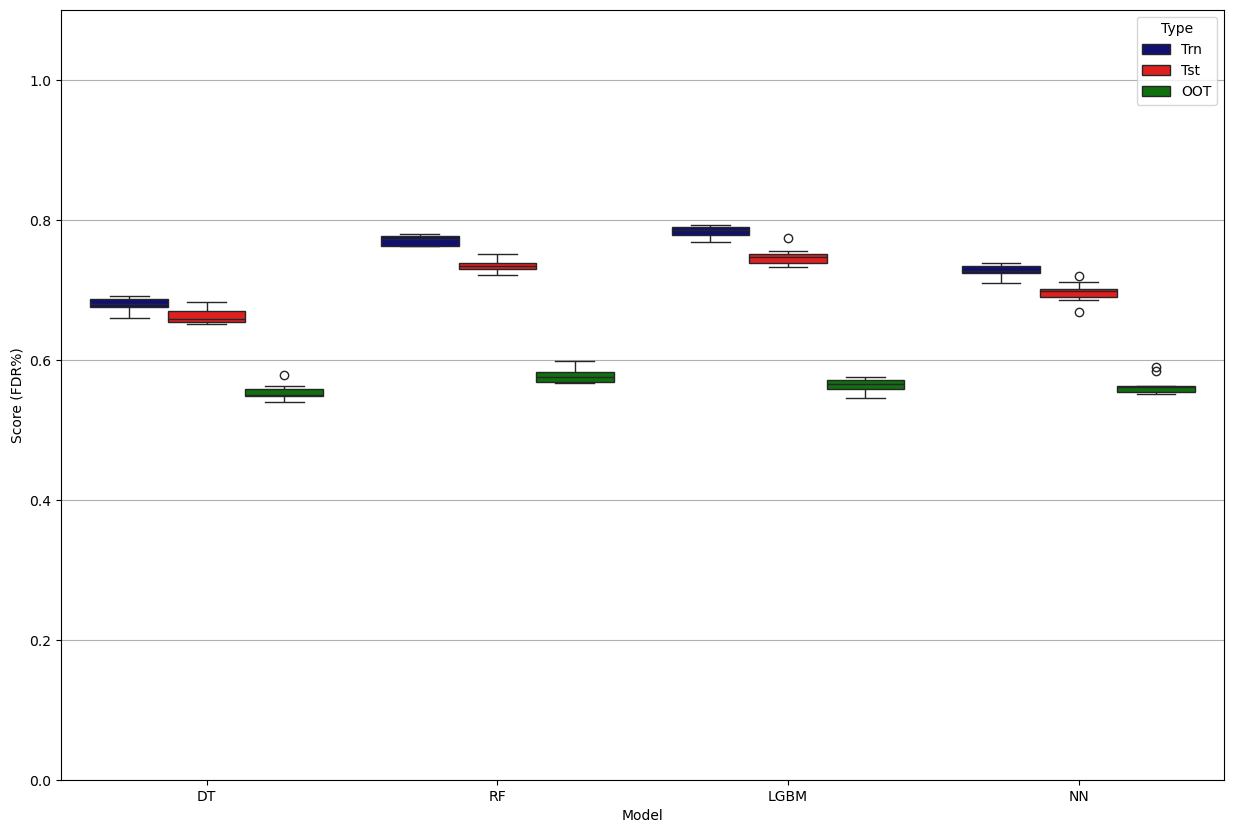

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(0.,1.1)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [122]:
print('duration: ', datetime.now() - start_time)

duration:  0:00:59.108087


In [123]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


This next cell can be used to explore overfitting

In [124]:
from catboost import CatBoostClassifier

In [ ]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,5):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        # model = DecisionTreeClassifier(
        # criterion='entropy',
        # splitter='best',
        # max_depth=None,            # no depth limit
        # min_samples_split=2,       # split with just 2 samples
        # min_samples_leaf=1         # leaves can be 1 sample
        # )

 
        # RandomForestClassifier(
        #         max_depth=29,                # still deep enough to overfit
        #         criterion='entropy',         # sensitive to information gain
        #         n_estimators=101,            # fewer trees → much faster than 1000
        #         min_samples_split=2,         # very flexible splitting
        #         min_samples_leaf=1,          # allows pure leaves
        #     )
        
        # MLPClassifier(
        # hidden_layer_sizes=(100,100),
        # activation='relu',
        # solver='adam',
        # alpha=0.001,
        # learning_rate='constant',
        # learning_rate_init = 0.001
        # )
        
        # model = xgb.XGBClassifier(
        # booster='gbtree',
        # max_depth=15,
        # learning_rate=0.01,
        # n_estimators=1000,
        # subsample=0.85,
        # colsample_bytree=0.75,
        # reg_alpha=0.1,
        # reg_lambda=0.5,
        # use_label_encoder=False,
        # eval_metric='logloss'
        # )
        
        # sm = SMOTE()
    
        # X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
        
        # lgb.LGBMClassifier(
        #     n_estimators = 60,
        #     learning_rate =0.25,
        #     max_depth = 3,
        #     num_leaves = 8,
        #     min_child_samples = 15)
        best_params = {
        'bootstrap_type': 'Bayesian',
        'depth': 16,
        'iterations': 3000,
        'l2_leaf_reg': 12,
        'learning_rate': 0.01,
        'random_state': 10,
        'verbose': 0
        }
        model = CatBoostClassifier(**best_params)
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True)
table.plot()
plt.title('Catboost')
plt.savefig('model performance/complexity_NN.pdf', format='pdf')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
best_OOT

0.5955056179775281

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [126]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.
# desire = best_OOT * .95
desire = .57
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice
    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.57
[LightGBM] [Info] Number of positive: 1496, number of negative: 58284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 59780, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025025 -> initscore=-3.662533
[LightGBM] [Info] Start training from score -3.662533
0 0.9385026737967914 0.75625 0.5589887640449438
[LightGBM] [Info] Number of positive: 1483, number of negative: 58297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the trai

In [127]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [128]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,predicted,Fraud
90576,-0.462456,11.466361,1.299601,1.498931,0.919760,1.148172,-0.492299,-0.730147,-0.591096,-0.591614,0.969071,1.0
91312,3.817913,-0.282889,1.299601,-0.294748,0.919760,1.148172,0.703334,0.761379,1.190137,1.188769,0.966378,0.0
95672,8.098282,-0.342687,-1.175006,0.386161,0.919760,-0.246748,0.572118,6.727486,9.650991,9.645589,0.964912,1.0
90577,-0.462456,11.664029,1.299601,1.498931,0.919760,1.148172,-0.270733,-0.730147,-0.591096,-0.591614,0.962417,1.0
95636,6.875320,-0.277436,-1.193344,0.386161,0.919760,-1.409182,0.385219,5.534264,7.869758,7.865206,0.959646,0.0
91507,7.486801,-0.343360,1.299601,-0.185820,0.919760,1.148172,2.379578,5.235959,7.424450,7.420110,0.950256,1.0
94561,7.486801,-0.343830,1.299601,-0.114904,0.919760,1.148172,0.759355,3.446127,4.307294,4.304440,0.950184,1.0
96865,6.875320,-0.342341,1.299601,-0.188893,0.919760,1.148172,-0.524241,-0.730147,-0.591096,-0.591614,0.949880,1.0
91499,6.875320,-0.269190,1.299601,-0.185820,0.919760,1.148172,2.323922,4.937654,6.979142,6.975014,0.948490,1.0
92216,7.486801,-0.080290,1.299601,-0.120659,0.919760,1.148172,-0.611604,-0.730147,-0.591096,-0.591614,0.948028,1.0


In [129]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,20.0,106.0,15.873016,84.126984,126.0,20.0,106.0,0.162853,29.775281,29.612428,0.188679
2,2.0,127.0,62.0,65.0,48.818898,51.181102,253.0,82.0,171.0,0.667698,48.033708,47.366010,0.479532
3,3.0,126.0,93.0,33.0,73.809524,26.190476,379.0,175.0,204.0,1.424965,57.303371,55.878405,0.857843
4,4.0,126.0,102.0,24.0,80.952381,19.047619,505.0,277.0,228.0,2.255517,64.044944,61.789427,1.214912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,127.0,127.0,0.0,100.000000,0.000000,12132.0,11776.0,356.0,95.887957,100.000000,4.112043,33.078652
97,97.0,126.0,126.0,0.0,100.000000,0.000000,12258.0,11902.0,356.0,96.913932,100.000000,3.086068,33.432584
98,98.0,126.0,126.0,0.0,100.000000,0.000000,12384.0,12028.0,356.0,97.939907,100.000000,2.060093,33.786517
99,99.0,127.0,127.0,0.0,100.000000,0.000000,12511.0,12155.0,356.0,98.974025,100.000000,1.025975,34.143258


Max possible savings: 57,168,000.0


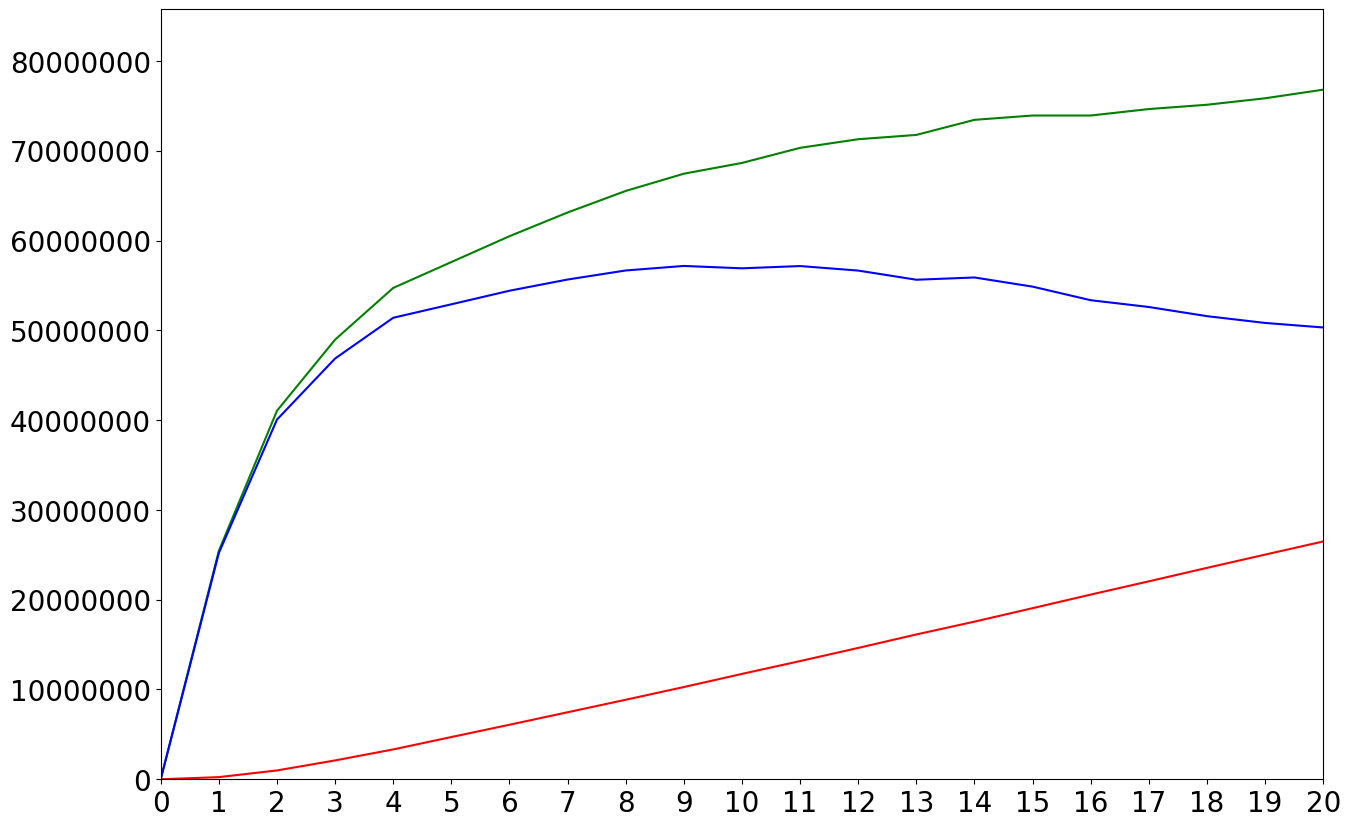

In [ ]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('model performance/savings.png', format='png')

✅ Best Cutoff Bin: 9
💰 Max Overall Savings: $57,168,000

📈 Cutoffs within 95% of max savings:
    Fraud Savings   FP Loss  Overall Savings
6        60480000   6072000         54408000
7        63120000   7464000         55656000
8        65520000   8856000         56664000
9        67440000  10272000         57168000
10       68640000  11736000         56904000
11       70320000  13164000         57156000
12       71280000  14628000         56652000
13       71760000  16128000         55632000
14       73440000  17556000         55884000
15       73920000  19056000         54864000


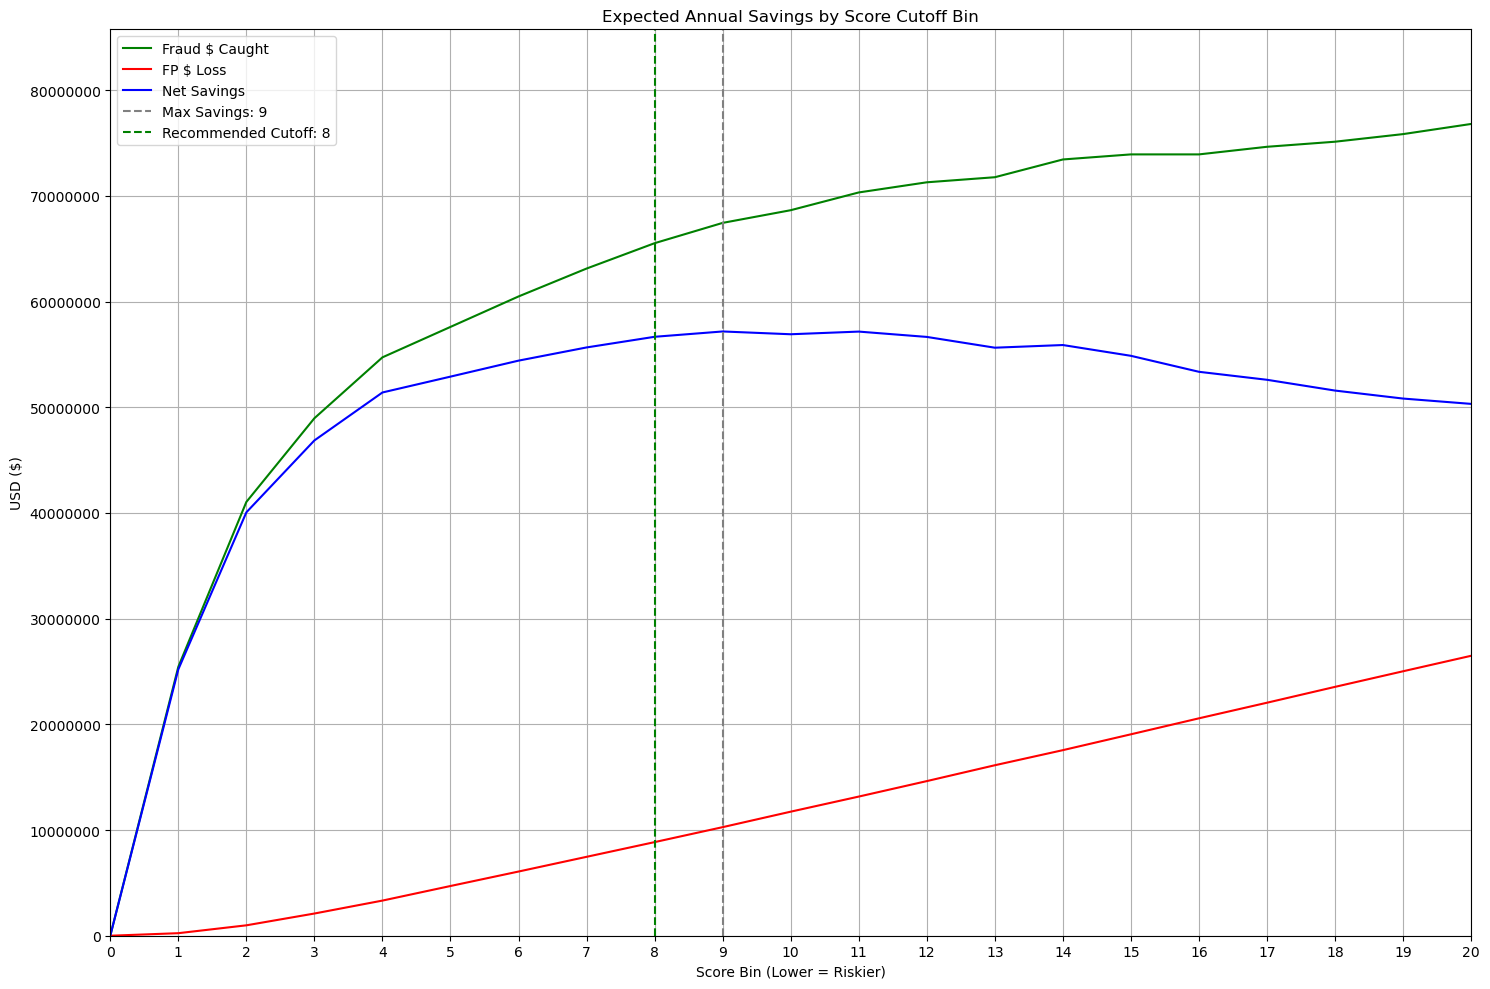

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes FDR_trn, FDR_tst, FDR_oot are already loaded DataFrames
cost_fraud = 400
cost_fp = 20
xoot = (12 / 2) * (10_000_000 / 100_000)

# Setup financial tables
num_bins = len(FDR_oot)
Financials_trn = pd.DataFrame(0, index=range(num_bins), columns=['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = Financials_trn.copy()
Financials_oot = Financials_trn.copy()

# Compute financials
for i in range(num_bins):
    for fin_df, fdr_df in zip(
        [Financials_trn, Financials_tst, Financials_oot],
        [FDR_trn, FDR_tst, FDR_oot]
    ):
        fin_df.loc[i, 'Fraud Savings'] = fdr_df.loc[i, 'cb'] * cost_fraud * xoot
        fin_df.loc[i, 'FP Loss'] = fdr_df.loc[i, 'cg'] * cost_fp * xoot
        fin_df.loc[i, 'Overall Savings'] = fin_df.loc[i, 'Fraud Savings'] - fin_df.loc[i, 'FP Loss']

# Identify best cutoff
best_cutoff_bin = Financials_oot['Overall Savings'].idxmax()
max_savings = Financials_oot.loc[best_cutoff_bin, 'Overall Savings']
print(f"✅ Best Cutoff Bin: {best_cutoff_bin}")
print(f"💰 Max Overall Savings: ${max_savings:,.0f}")

# Optional: highlight 'good enough' bins (within 95% of max savings)
threshold = 0.95 * max_savings
good_cutoffs = Financials_oot[Financials_oot['Overall Savings'] >= threshold]
print(f"\n📈 Cutoffs within 95% of max savings:\n{good_cutoffs}")

# Add bin info for clarity
Financials_oot.insert(0, "Bin", range(num_bins))

# Plot
yupper = max_savings * 1.5
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Bin'], Financials_oot['Fraud Savings'], color='green', label="Fraud $ Caught")
plt.plot(Financials_oot['Bin'], Financials_oot['FP Loss'], color='red', label="FP $ Loss")
plt.plot(Financials_oot['Bin'], Financials_oot['Overall Savings'], color='blue', label="Net Savings")
plt.axvline(x=best_cutoff_bin, color='gray', linestyle='--', label=f'Max Savings: {best_cutoff_bin}')
plt.axvline(x=best_cutoff_bin-1, color='green', linestyle='--', label=f'Recommended Cutoff: {best_cutoff_bin-1}')

plt.title("Expected Annual Savings by Score Cutoff Bin")
plt.xlabel("Score Bin (Lower = Riskier)")
plt.ylabel("USD ($)")
plt.ylim(0, yupper)
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 1))
plt.ticklabel_format(style='plain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("model performance/savings.png", format="png", dpi=300)
plt.show()


In [131]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,20.0,106.0,15.873016,84.126984,126.0,20.0,106.0,0.162853,29.775281,29.612428,0.188679
2,2.0,127.0,62.0,65.0,48.818898,51.181102,253.0,82.0,171.0,0.667698,48.033708,47.366010,0.479532
3,3.0,126.0,93.0,33.0,73.809524,26.190476,379.0,175.0,204.0,1.424965,57.303371,55.878405,0.857843
4,4.0,126.0,102.0,24.0,80.952381,19.047619,505.0,277.0,228.0,2.255517,64.044944,61.789427,1.214912
5,5.0,127.0,115.0,12.0,90.551181,9.448819,632.0,392.0,240.0,3.191922,67.415730,64.223808,1.633333
6,6.0,126.0,114.0,12.0,90.476190,9.523810,758.0,506.0,252.0,4.120186,70.786517,66.666331,2.007937
7,7.0,127.0,116.0,11.0,91.338583,8.661417,885.0,622.0,263.0,5.064734,73.876404,68.811670,2.365019
8,8.0,126.0,116.0,10.0,92.063492,7.936508,1011.0,738.0,273.0,6.009283,76.685393,70.676111,2.703297
9,9.0,126.0,118.0,8.0,93.650794,6.349206,1137.0,856.0,281.0,6.970116,78.932584,71.962468,3.046263


In [ ]:
FDR.to_csv('model performance/FDR.csv')

In [ ]:
FDR_trn.to_csv('model performance/FDR_trn.csv', index=False)
FDR_tst.to_csv('model performance/FDR_tst.csv', index=False)
FDR_oot.to_csv('model performance/FDR_oot.csv', index=False)

In [134]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

12281.0 356.0 12637.0 12637.0


In [ ]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('model performance/Metrics.csv')

Text(0, 0.5, 'FDR')

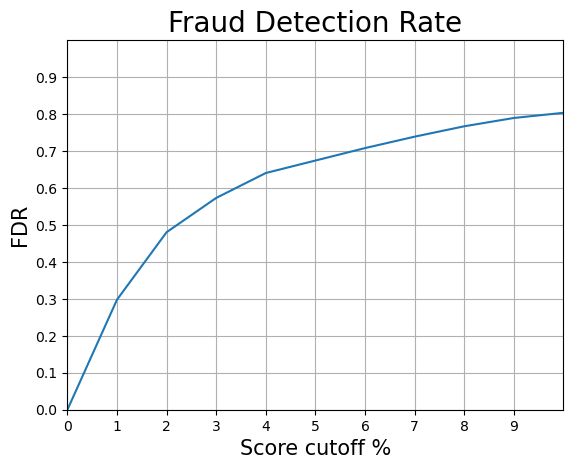

In [136]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.grid()
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

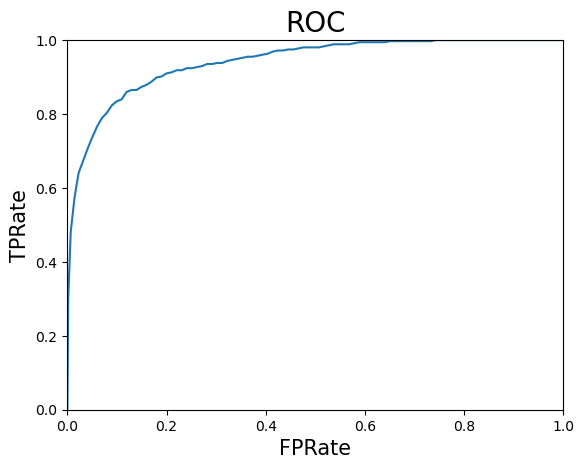

In [137]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [138]:
print("duration: ", datetime.now() - start_time)

duration:  0:02:23.801544


In [139]:
%pwd

'/home/jovyan/SP25/Fraud_Analytics/HW4'

In [140]:
%%time
df = pd.read_csv('card transactions_2025.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 86 ms, sys: 8.82 ms, total: 94.8 ms
Wall time: 98.9 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(98037, 10)

In [141]:
df['prediction'] = model.predict_proba(X)[:,1]

In [142]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [143]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000012
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000442
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.001486
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000012
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000012


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98037 entries, 0 to 98392
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             98037 non-null  int64         
 1   Cardnum            98037 non-null  int64         
 2   Date               98037 non-null  datetime64[ns]
 3   Merchnum           94791 non-null  object        
 4   Merch description  98037 non-null  object        
 5   Merch state        97000 non-null  object        
 6   Merch zip          93664 non-null  float64       
 7   Transtype          98037 non-null  object        
 8   Amount             98037 non-null  float64       
 9   Fraud              98037 non-null  int64         
 10  prediction         98037 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 9.0+ MB


In [145]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
75432,75433,5142299705,2010-09-16,6070095870009,THE HOME DEPOT 4702,WA,98134.0,P,905.00,1,1.000000
64061,64062,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,891.97,1,0.998497
64229,64230,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,787.40,1,0.995712
64095,64096,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,896.91,1,0.995712
38477,38478,5142189341,2010-05-21,9108234610000,STAPLES #941,PA,17201.0,P,852.29,1,0.994393
64252,64253,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,871.70,1,0.994380
65992,65993,5142140316,2010-08-19,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,3767.69,1,0.992954
63888,63889,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,717.17,1,0.992088
63905,63906,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,728.95,1,0.992088
65998,65999,5142140316,2010-08-19,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,485.14,1,0.991825


# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [146]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142223373    42
5142197711    42
5142220474    42
5142189341    41
5142225942    41
5142160778    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
Name: count, dtype: int64

In [147]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     205
4353000719908    118
9900020006406     51
9108234610000     50
8834000695423     46
4503738417400     45
4620009957157     41
4503082476300     40
900009045549      37
618901687330      36
253052983001      35
938909877224      32
6006333528866     30
997674930332      30
6070095870009     28
Name: count, dtype: int64

In [148]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

/tmp/ipykernel_5228/2861435870.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(sample['Date'],sample['Fraud'])


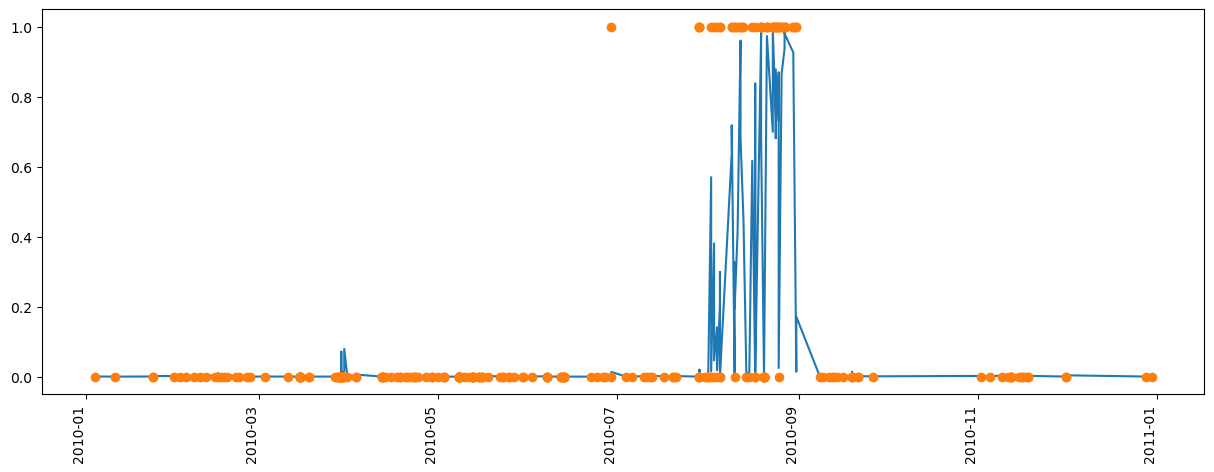

In [149]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [150]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.569778
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.015198
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.380431
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.046491
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.141512


/tmp/ipykernel_5228/2407391654.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(tsample['Date'],tsample['Fraud'])


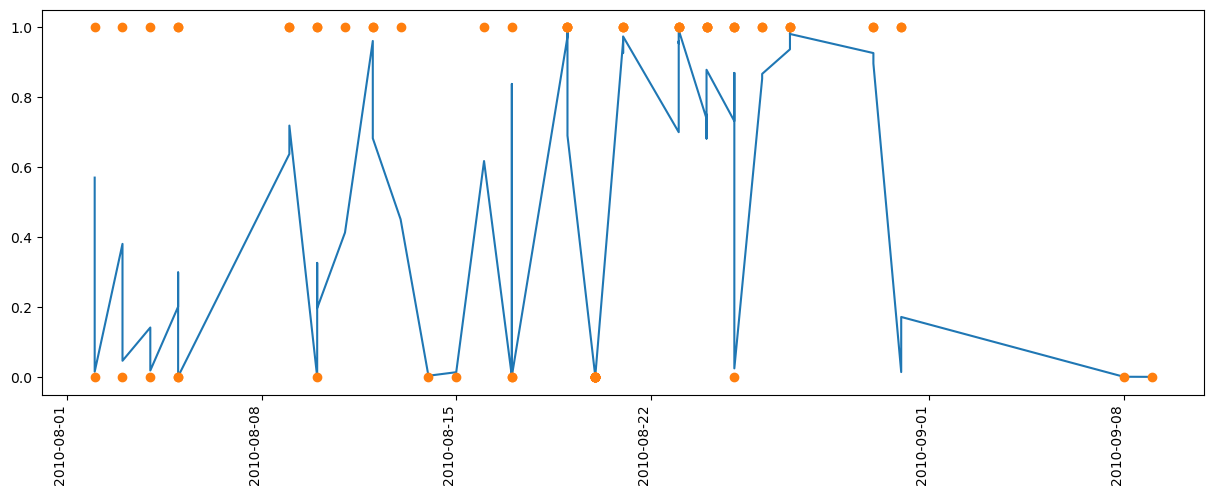

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('model performance/dynamics_time.png', format='png')

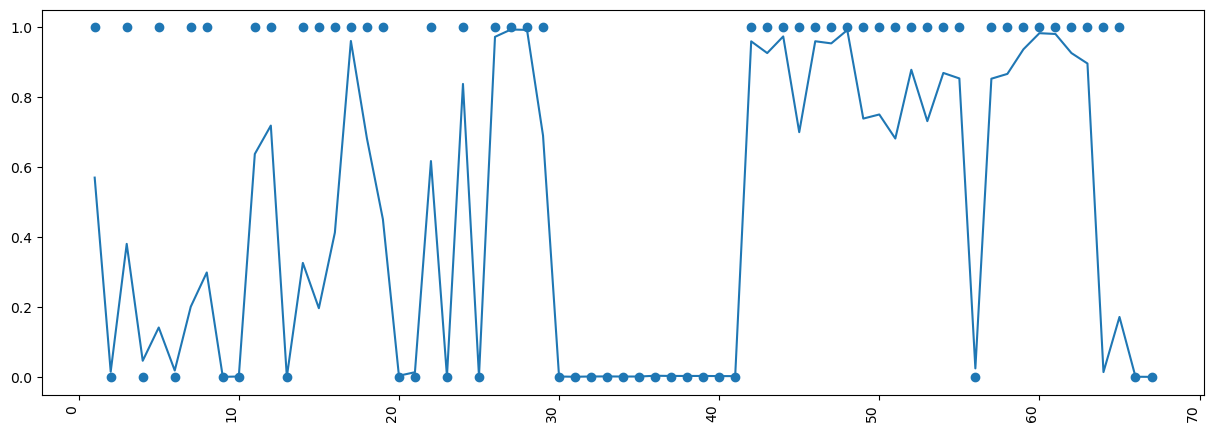

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('model performance/dynamics_count.png', format='png')

In [ ]:
tsample.to_csv('model performance/dynamics_transactions.csv')
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.569778
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.015198
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.380431
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.046491
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.141512
5,6,60993,60994,5142140316,2010-08-04,4620002006336,HP GSA STORE,AZ,85285.0,P,1060.00,0,0.018583
6,7,61041,61042,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,629.09,1,0.200905
7,8,61044,61045,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1821.05,1,0.298752
8,9,61111,61112,5142140316,2010-08-05,930090121224,FEDEX SHP 07/24/10 AB#,TN,38118.0,P,5.16,0,0.000517
9,10,61145,61146,5142140316,2010-08-05,930090121224,FEDEX SHP 07/21/10 AB#,TN,38118.0,P,3.57,0,0.001515


In [154]:
len(tsample)

67

# Score Calibration

In [155]:
base = 600
delta = 20
odds_at_base = .1

In [156]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(98037, 12)

In [157]:
df.head()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,predicted,Fraud
25112,-0.462456,-0.198874,-0.633344,-0.538458,0.919760,1.148172,-0.037506,-0.431842,-0.591096,-0.591614,0.000688,0.0
11075,-0.462456,-0.325274,-1.191046,-0.715578,-1.789217,-1.607368,-0.699416,1.656295,-0.591096,-0.591614,0.000014,0.0
75411,-0.462456,-0.147140,1.299601,-0.477107,0.919760,1.148172,-0.329040,-0.431842,-0.591096,-0.591614,0.003727,0.0
19571,-0.462456,-0.308776,1.299601,-0.610214,0.919760,1.148172,0.242367,-0.431842,-0.591096,-0.591614,0.001625,0.0
32708,-0.462456,-0.334648,1.299601,-0.082161,0.919760,1.148172,-0.192991,-0.730147,-0.591096,-0.591614,0.000732,0.0


In [158]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/tmp/ipykernel_5228/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/tmp/ipykernel_5228/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

,score_raw,Fraud
64239,0.00001,0.0
22654,0.00001,0.0
42587,0.00001,0.0
13205,0.00001,0.0
48467,0.00001,0.0


In [159]:
calib.shape

(98037, 2)

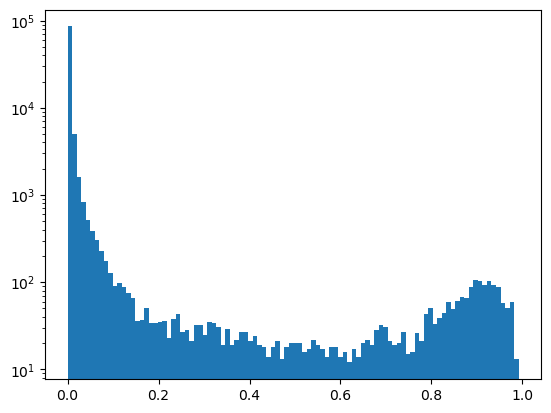

In [160]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [161]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [162]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2492.0 95545.0


In [163]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,980.0,979.0,1.0,99.897959,0.102041,980.0,979.0,1.0,0.000012,0.102041,0.001022,-9.933723,-8.000000
2,2.0,981.0,981.0,0.0,100.000000,0.000000,1962.0,1960.0,1.0,0.000019,0.000000,0.000001,-19.903894,-8.000000
3,3.0,980.0,980.0,0.0,100.000000,0.000000,2940.0,2940.0,1.0,0.000025,0.000000,0.000001,-19.902422,-8.000000
4,4.0,980.0,980.0,0.0,100.000000,0.000000,3920.0,3920.0,1.0,0.000035,0.000000,0.000001,-19.902422,-8.000000
5,5.0,981.0,981.0,0.0,100.000000,0.000000,4905.0,4901.0,1.0,0.000046,0.000000,0.000001,-19.903894,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,981.0,932.0,49.0,95.005097,4.994903,94176.0,93813.0,303.0,0.053170,4.994903,0.052576,-4.249447,-4.249447
97,97.0,980.0,866.0,114.0,88.367347,11.632653,95060.0,94679.0,417.0,0.095309,11.632653,0.131641,-2.925321,-2.925321
98,98.0,980.0,598.0,382.0,61.020408,38.979592,96040.0,95277.0,799.0,0.285440,38.979592,0.638798,-0.646569,-0.646569
99,99.0,981.0,230.0,751.0,23.445464,76.554536,97119.0,95507.0,1550.0,0.712921,76.554536,3.265222,1.707181,1.707181


In [164]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,981.0,932.0,49.0,95.005097,4.994903,94176.0,93813.0,303.0,0.053170,4.994903,0.052576,-4.249447,-4.249447
97,97.0,980.0,866.0,114.0,88.367347,11.632653,95060.0,94679.0,417.0,0.095309,11.632653,0.131641,-2.925321,-2.925321
98,98.0,980.0,598.0,382.0,61.020408,38.979592,96040.0,95277.0,799.0,0.285440,38.979592,0.638798,-0.646569,-0.646569
99,99.0,981.0,230.0,751.0,23.445464,76.554536,97119.0,95507.0,1550.0,0.712921,76.554536,3.265222,1.707181,1.707181
100,100.0,980.0,38.0,942.0,3.877551,96.122449,98000.0,95545.0,2492.0,0.920684,96.122449,24.789500,4.631657,4.631657


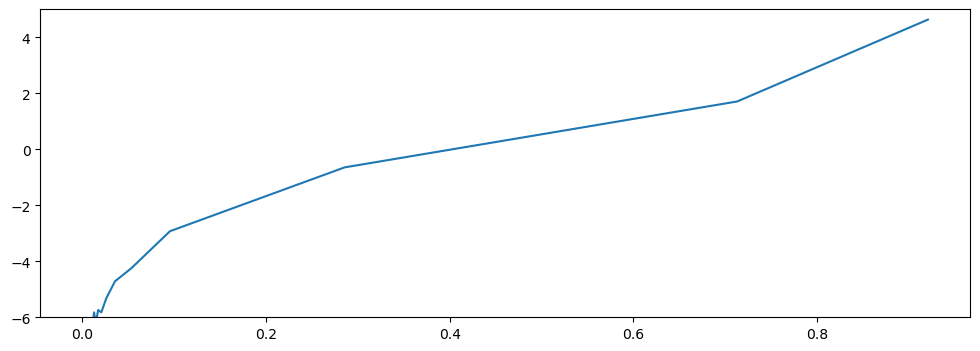

In [165]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [166]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [167]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[7.82440446e-01 9.14033991e-01 7.10926131e-04]


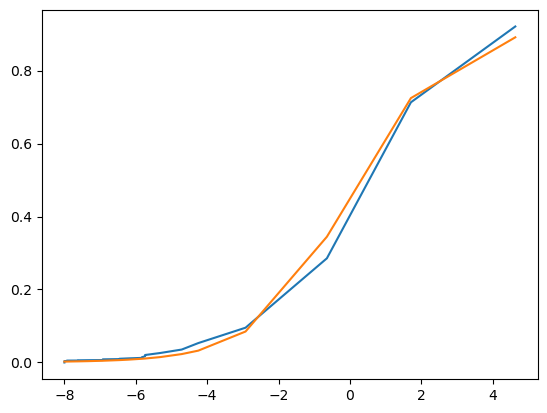

In [168]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


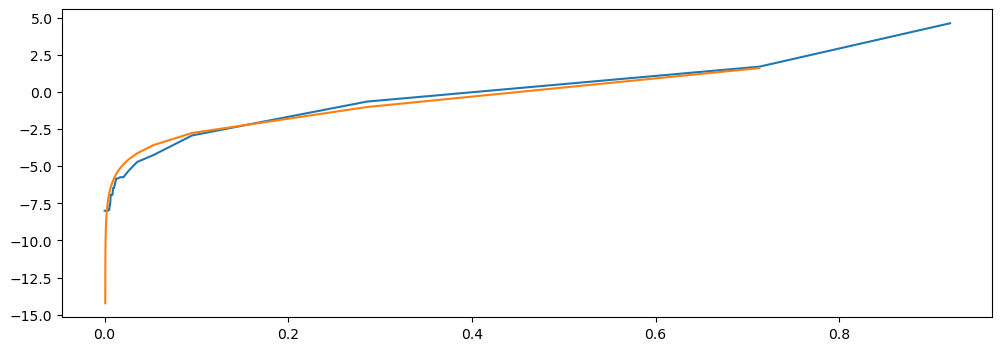

In [169]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [170]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,980.0,979.0,1.0,99.897959,0.102041,980.0,979.0,1.0,0.000012,0.102041,0.001022,-9.933723,-8.0,NaN
2,2.0,981.0,981.0,0.0,100.000000,0.000000,1962.0,1960.0,1.0,0.000019,0.000000,0.000001,-19.903894,-8.0,NaN
3,3.0,980.0,980.0,0.0,100.000000,0.000000,2940.0,2940.0,1.0,0.000025,0.000000,0.000001,-19.902422,-8.0,NaN
4,4.0,980.0,980.0,0.0,100.000000,0.000000,3920.0,3920.0,1.0,0.000035,0.000000,0.000001,-19.902422,-8.0,NaN
5,5.0,981.0,981.0,0.0,100.000000,0.000000,4905.0,4901.0,1.0,0.000046,0.000000,0.000001,-19.903894,-8.0,NaN
6,6.0,980.0,980.0,0.0,100.000000,0.000000,5880.0,5881.0,1.0,0.000066,0.000000,0.000001,-19.902422,-8.0,NaN
7,7.0,981.0,981.0,0.0,100.000000,0.000000,6867.0,6862.0,1.0,0.000084,0.000000,0.000001,-19.903894,-8.0,NaN
8,8.0,980.0,979.0,1.0,99.897959,0.102041,7840.0,7841.0,2.0,0.000104,0.102041,0.001022,-9.933723,-8.0,NaN
9,9.0,980.0,980.0,0.0,100.000000,0.000000,8820.0,8821.0,2.0,0.000124,0.000000,0.000001,-19.902422,-8.0,NaN
10,10.0,981.0,981.0,0.0,100.000000,0.000000,9810.0,9802.0,2.0,0.000145,0.000000,0.000001,-19.903894,-8.0,NaN


In [171]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/tmp/ipykernel_5228/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_5228/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [172]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
71,71.0,980.0,976.0,4.0,99.591837,0.408163,69580.0,69560.0,46.0,0.004017,0.408163,0.004099,-7.930377,-7.930377,-7.180906,522.820441
72,72.0,981.0,977.0,4.0,99.592253,0.407747,70632.0,70537.0,50.0,0.004176,0.407747,0.004095,-7.931854,-7.930377,-7.120278,524.032993
73,73.0,980.0,979.0,1.0,99.897959,0.102041,71540.0,71516.0,51.0,0.004343,0.102041,0.001022,-9.933723,-7.930377,-7.060239,525.233776
74,74.0,980.0,980.0,0.0,100.000000,0.000000,72520.0,72496.0,51.0,0.004517,0.000000,0.000001,-19.902422,-7.930377,-7.000179,526.434981
75,75.0,981.0,978.0,3.0,99.694190,0.305810,73575.0,73474.0,54.0,0.004714,0.305810,0.003069,-8.348247,-7.930377,-6.935381,527.730940
76,76.0,980.0,979.0,1.0,99.897959,0.102041,74480.0,74453.0,55.0,0.004925,0.102041,0.001022,-9.933723,-7.930377,-6.869147,529.055614
77,77.0,980.0,977.0,3.0,99.693878,0.306122,75460.0,75430.0,58.0,0.005151,0.306122,0.003072,-8.346771,-7.930377,-6.802129,530.395973
78,78.0,981.0,976.0,5.0,99.490316,0.509684,76518.0,76406.0,63.0,0.005401,0.509684,0.005124,-7.608521,-7.608521,-6.731968,531.799201
79,79.0,980.0,977.0,3.0,99.693878,0.306122,77420.0,77383.0,66.0,0.005680,0.306122,0.003072,-8.346771,-7.608521,-6.657707,533.284431
80,80.0,981.0,979.0,2.0,99.796126,0.203874,78480.0,78362.0,68.0,0.005980,0.203874,0.002044,-8.934444,-7.608521,-6.582309,534.792380


In [173]:
calib.head()

,score_raw,Fraud
64239,0.00001,0.0
22654,0.00001,0.0
42587,0.00001,0.0
13205,0.00001,0.0
48467,0.00001,0.0


In [174]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/tmp/ipykernel_5228/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_5228/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

,score_raw,Fraud,score_calib
64239,0.00001,0.0,675.593156
22654,0.00001,0.0,675.593156
42587,0.00001,0.0,675.593156
13205,0.00001,0.0,675.593156
48467,0.00001,0.0,675.593156


In [175]:
calib.tail()

,score_raw,Fraud,score_calib
38363,0.986005,1.0,678.953897
64010,0.987312,1.0,678.957940
63876,0.987312,1.0,678.957940
63842,0.990074,1.0,678.966475
75147,0.991564,1.0,678.971077


In [176]:
calib.describe()

,score_raw,Fraud,score_calib
count,98037.000000,98037.000000,98037.000000
mean,0.024042,0.025419,675.676988
std,0.119144,0.157395,0.411408
min,0.000010,0.000000,675.593156
25%,0.000524,0.000000,675.594994
50%,0.001781,0.000000,675.599489
75%,0.004824,0.000000,675.610370
max,0.991564,1.000000,678.971077


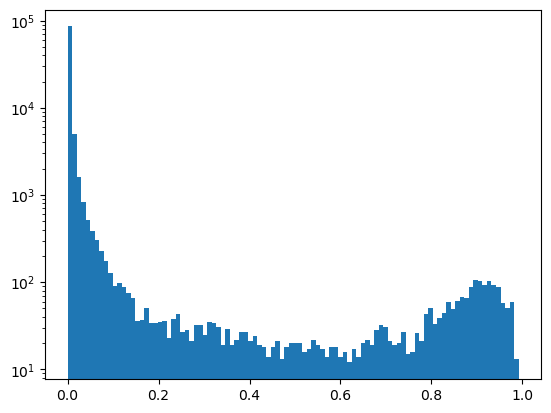

In [177]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

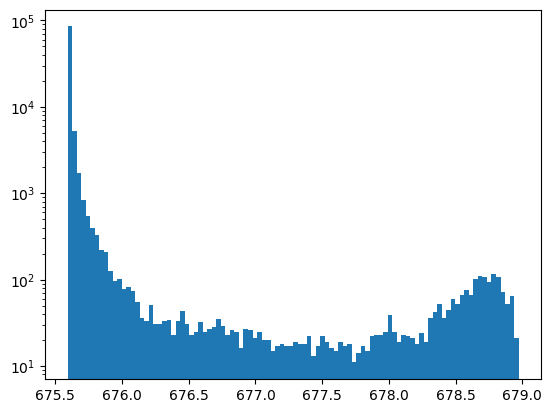

In [178]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

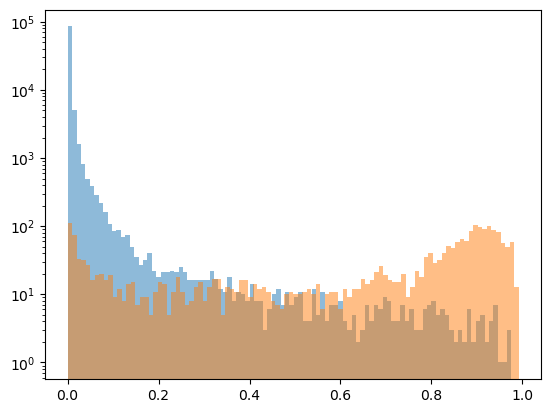

In [179]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

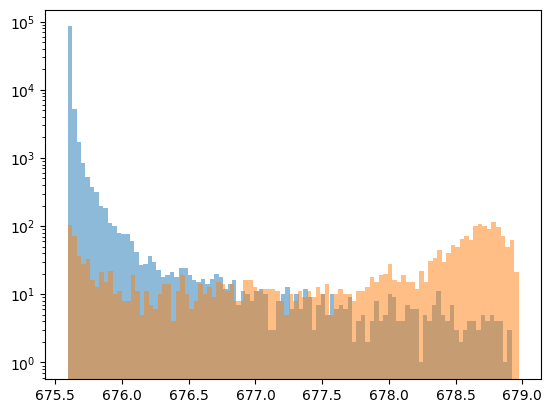

In [180]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [181]:
import scipy.stats as sps
KS = sps.ks_2samp(goods['score_raw'],bads['score_raw'])[0]
print(KS)

0.8753652590482227


In [182]:
print("duration: ", datetime.now() - start_time)

duration:  0:02:25.822280


In [183]:
%pwd

'/home/jovyan/SP25/Fraud_Analytics/HW4'